In [ ]:
#pip install git+https://github.com/tensorflow/docs

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Load matplotlib inline extension
%matplotlib inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [15]:
logs_base_dir = pathlib.Path("./fmri")/"tensorboard_logs"
shutil.rmtree(logs_base_dir, ignore_errors=True)

In [16]:
%tensorboard --logdir "./fmri/tensorboard_logs" --host 0.0.0.0

Reusing TensorBoard on port 6007 (pid 67681), started 0:02:22 ago. (Use '!kill 67681' to kill it.)

In [17]:
#Load data from hdf5 file
seed=38

# origin h5 file location, load and shuffle timeseries
h5_file = '/data/elekin/data/results/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5'

#windows
#h5_file = "Z:/elekin/02-RESULTADOS/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5"

tr_key = 'cbl/dataset'#transformed dataset (id,time series matrix 158x28, label)
dataset = pd.read_hdf(h5_file, tr_key)

num_samples = dataset.shape[0]
features = np.stack(dataset['features'].values)
labels = dataset['label'].values.astype('int8')

features.shape, labels.shape

((101, 158, 28), (101,))

In [19]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33)

In [20]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=0.001),
        tf.keras.callbacks.TensorBoard(logs_base_dir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=None, use_multiprocessing=True, 
                        validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                        verbose=0)
    return history

## Recurrent Neural Network LSTM

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [21]:
STEPS_PER_EPOCH = 1
FEATURES = 158
CHANNELS = 28

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  1e-6,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [22]:
size_histories = {}

In [23]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/tiny'] = compile_and_fit(lstm, "lstm/tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                5088      
_________________________________________________________________
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4776,  loss:0.6919,  val_accuracy:0.4412,  val_loss:0.6949,  
....................................................................................................
Epoch: 100, accuracy:0.4776,  loss:0.6919,  val_accuracy:0.4412,  v

In [ ]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.LSTM(256, activation=tf.nn.tanh),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['lstm/small'] = compile_and_fit(small, "lstm/small", optimizer=None, max_epochs=10000)

(0.0, 2.15)

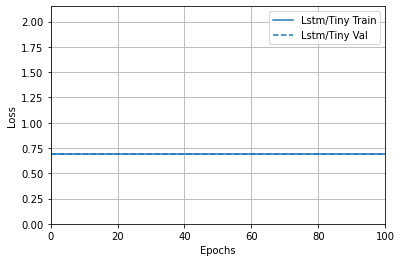

In [24]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 2.15])

(0.3, 1.02)

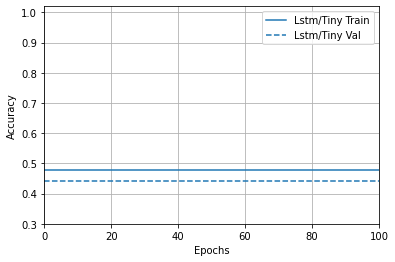

In [25]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0.3, 1.02])

## Bidirectional

In [26]:
shutil.rmtree(logs_base_dir/'lstm/regularizers/tiny', ignore_errors=True)
shutil.copytree(logs_base_dir/'lstm/tiny', logs_base_dir/'lstm/regularizers/tiny')
regularizer_histories = {}
#regularizer_histories['tiny'] = size_histories['lstm/tiny']

In [27]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.relu),input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation=tf.nn.relu)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
regularizer_histories['bi-tiny'] = compile_and_fit(lstm, "lstm/regularizers/bi-tiny", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 158, 512)          583680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,166,945
Trainable params: 2,166,945
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4925,  loss:0.6932,  val_accuracy:0.5294,  val_loss:0.6932,  
............................

KeyboardInterrupt: 

### Regularization

In [ ]:
# Drop out
dr=0.2
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True, activation=tf.nn.tanh,input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.LSTM(128, activation=tf.nn.tanh),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)],)
regularizer_histories['drop-tiny'] = compile_and_fit(lstm, "lstm/regularizers/drp-tiny", optimizer=None, max_epochs=10000)

In [ ]:
# Drop out
dr=0.25
lr=1e-6
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, activation=tf.nn.tanh, kernel_regularizer=regularizers.l2(lr), input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(lr)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l2(lr))],)
regularizer_histories['kernel'] = compile_and_fit(lstm, "lstm/regularizers/kernel-reg", optimizer=None, max_epochs=10000)

In [ ]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 2.15])

In [ ]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(regularizer_histories)
plt.ylim([0.3, 1.02])